## Benchmarking

Below we benchmark simple timing of leaky, StateLeaky, and LinearLeaky.

In [2]:
# dims used for the benchmark of:
# - Leaky
# - StateLeaky
# - LinearLeaky

timesteps = 2000
batch = 64
channels = 1000


In [3]:
# benchmark Leaky

import torch
import time
import snntorch as snn

lif = snn.Leaky(beta=0.9)
lif = lif.to('cuda')

x = torch.rand((timesteps, batch, channels)).to('cuda')
mem = torch.zeros(batch, channels).to('cuda')
spk = torch.zeros(batch, channels).to('cuda')

start_time = time.time()
for step in range(timesteps):
  spk, mem = lif(x[step], mem=mem)
end_time = time.time()

print(f"{end_time-start_time}")

0.19113922119140625


In [4]:
# benchmark StateLeaky

import torch
import time
from snntorch._neurons.stateleaky import StateLeaky

layer = StateLeaky(beta=0.9, channels=channels).to('cuda')

# warmup
input_ = torch.arange(1, timesteps * batch * channels + 1).float().view(timesteps, batch, channels).to('cuda')
layer.forward(input_)

# timing
input_ = torch.arange(1, timesteps * batch * channels + 1).float().view(timesteps, batch, channels).to('cuda')
input_ = torch.rand_like(input_)
start_time = time.time()
layer.forward(input_)
end_time = time.time()

print(f"{end_time-start_time}")

0.0009756088256835938


In [5]:
# benchmark LinearLeaky

import torch
import time
import snntorch as snn

timesteps = 2000
batch = 64
channels = 1000

layer = snn.LinearLeaky(in_features=channels, out_features=channels, beta=0.9).to('cuda')
# lif = torch.compile(lif, mode="reduce-overhead", fullgraph=True, dynamic=False)

# warmup
input_ = torch.arange(1, timesteps * batch * channels + 1).float().view(timesteps, batch, channels).to('cuda')
layer.forward(input_)

# timing
input_ = torch.arange(1, timesteps * batch * channels + 1).float().view(timesteps, batch, channels).to('cuda')
input_ = torch.rand_like(input_)
start_time = time.time()
layer.forward(input_)
end_time = time.time()

print(f"{end_time-start_time}")

0.008238792419433594


## Timing plot for StateLeaky vs Leaky

We expect StateLeaky to be a big performance boost

Benchmark Results:

Timesteps  |  Leaky (s)  |  Linear Leaky (s)  |  Ratio (T2/T1)
-------------------------------------------------------
       10 |     0.0011 |     0.0002 |       0.14
       27 |     0.0026 |     0.0001 |       0.05
       77 |     0.0071 |     0.0001 |       0.02
      215 |     0.0234 |     0.0003 |       0.01
      599 |     0.0551 |     0.0002 |       0.00
     1668 |     0.1531 |     0.0003 |       0.00
     4641 |     0.4248 |     0.0003 |       0.00
    12915 |     1.1622 |     0.0003 |       0.00
    35938 |     3.2193 |     0.0005 |       0.00
   100000 |     9.0245 |     0.0007 |       0.00


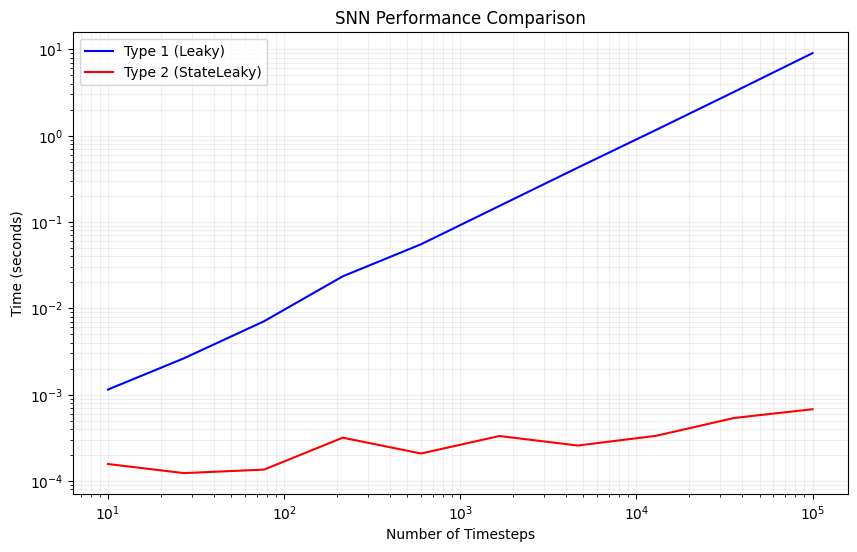

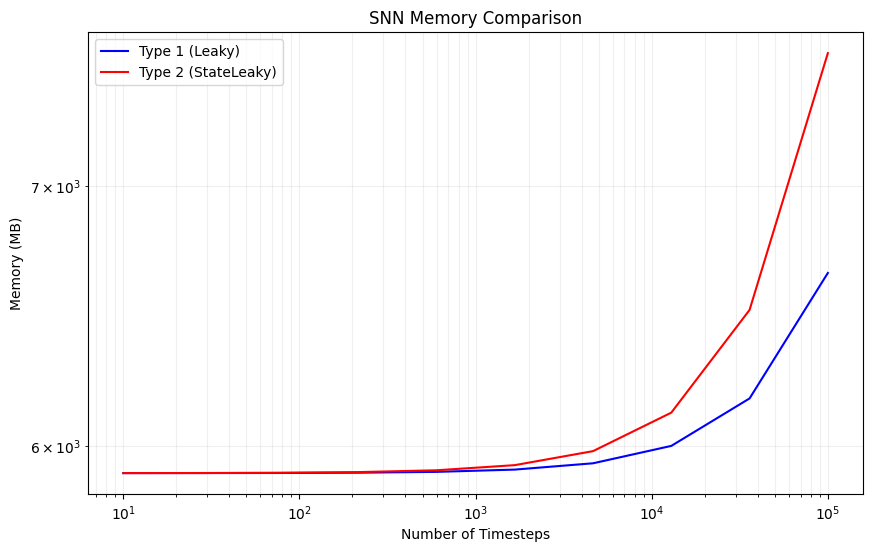

In [6]:
# timing plot for StateLeaky vs Leaky

import torch
import time
import snntorch as snn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from snntorch._neurons.stateleaky import StateLeaky

BATCH_SIZE = 20
CHANNELS = 20

device = "cuda"

def get_peak_memory(device):
    """Gets the peak GPU memory usage in MB."""
    return torch.cuda.max_memory_allocated(device) / 1024**2

def bench_type1(num_steps):
    lif = snn.Leaky(beta=0.9).to(device)
    x = torch.rand(num_steps).to(device)
    mem = torch.zeros(BATCH_SIZE, CHANNELS).to(device)
    spk = torch.zeros(BATCH_SIZE, CHANNELS).to(device)
    
    start_time = time.time()
    for step in range(num_steps):
        spk, mem = lif(x[step], mem=mem)
    end_time = time.time()
    
    return end_time - start_time

def bench_type2(timesteps):
    lif = StateLeaky(beta=0.9, channels=CHANNELS).to(device)
    input_ = torch.arange(1, timesteps * BATCH_SIZE * CHANNELS + 1).float().view(timesteps, BATCH_SIZE, CHANNELS).to(device)
    
    start_time = time.time()
    lif.forward(input_)
    end_time = time.time()
    
    return end_time - start_time

# define timesteps on log scale
timesteps = np.logspace(1, 5, num=10, dtype=int)

# run benchmarks
times1 = []
times2 = []
mems1 = []
mems2 = []
for steps in timesteps:
    # run each benchmark multiple times and take average for more stable results
    n_runs = 2

    times_1_run_accumulated = []
    times_2_run_accumulated = []
    mems_1_run_accumulated = []
    mems_2_run_accumulated = []
    for _ in range(n_runs):
        torch.cuda.synchronize()
        torch.cuda.reset_peak_memory_stats(device)
        time1 = bench_type1(steps)
        torch.cuda.synchronize()
        mem1 = get_peak_memory(device)

        torch.cuda.synchronize()
        torch.cuda.reset_peak_memory_stats(device)
        time2 = bench_type2(steps)
        torch.cuda.synchronize()
        mem2 = get_peak_memory(device)
        times_1_run_accumulated.append(time1)
        times_2_run_accumulated.append(time2)
        mems_1_run_accumulated.append(mem1)
        mems_2_run_accumulated.append(mem2)

    times1.append(np.mean(times_1_run_accumulated))
    times2.append(np.mean(times_2_run_accumulated))
    mems1.append(np.mean(mems_1_run_accumulated))
    mems2.append(np.mean(mems_2_run_accumulated))

# create the plot for time
plt.figure(figsize=(10, 6))
plt.plot(timesteps, times1, 'b-', label='Type 1 (Leaky)')
plt.plot(timesteps, times2, 'r-', label='Type 2 (StateLeaky)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlabel('Number of Timesteps')
plt.ylabel('Time (seconds)')
plt.title('SNN Performance Comparison')
plt.legend()
plt.savefig("snn_performance_comparison.svg", format="svg")

# create the plot for memory
plt.figure(figsize=(10, 6))
plt.plot(timesteps, mems1, 'b-', label='Type 1 (Leaky)')
plt.plot(timesteps, mems2, 'r-', label='Type 2 (StateLeaky)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlabel('Number of Timesteps')
plt.ylabel('Memory (MB)')
plt.title('SNN Memory Comparison')
plt.legend()
plt.savefig("snn_memory_comparison.svg", format="svg")

print("Benchmark Results:")
print("\nTimesteps  |  Leaky (s)  |  Linear Leaky (s)  |  Ratio (T2/T1)")
print("-" * 55)
for i, steps in enumerate(timesteps):
    ratio = times2[i] / times1[i]
    print(f"{steps:9d} | {times1[i]:10.4f} | {times2[i]:10.4f} | {ratio:10.2f}")

plt.show()

## Training an SNN LLM using StateLeaky

Proving that we can utilize StateLeaky for efficient learning

In [7]:
# confirm we can train a simple SNN language model with StateLeaky

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer
from snntorch._neurons.stateleaky import StateLeaky
from tqdm import tqdm
import torch.nn.functional as F
import wandb

with open("output.txt", "w") as f:
    f.write("\n")

def initialize_wandb():
    wandb.init(project="snntorch-ssm", config={
    })

# Hyperparameters
SEQ_LENGTH = 128
HIDDEN_DIM = 512
LR = 1e-3
EPOCHS = 10000
BATCH_SIZE = 64
LEARN_BETA = False 

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

# Load TinyStories dataset from Hugging Face
dataset = load_dataset("roneneldan/TinyStories", split="train")



# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")  # Use GPT-2 tokenizer for simplicity
tokenizer.pad_token = tokenizer.eos_token  # Use the end-of-sequence token as padding

print("initialized tokenizer")

VOCAB_SIZE = tokenizer.vocab_size

def tokenize_fn(example):
    tokens = tokenizer(example["text"], truncation=True, max_length=SEQ_LENGTH, padding="max_length")
    return {"input_ids": tokens["input_ids"]}

tokenized_dataset = dataset.map(tokenize_fn, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids"])

print("tokenized dataset")

dataloader = DataLoader(tokenized_dataset, batch_size=BATCH_SIZE, shuffle=True)

# NOTE: if we want to add multichannel learnable beta, helpful snippet:
# self.lif3 = StateLeaky(beta=torch.tensor([0.9]).expand(hidden_dim), channels=hidden_dim, learn_beta=True)
class SNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim):
        super(SNNLanguageModel, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.lif1 = StateLeaky(beta=0.9, channels=hidden_dim, learn_beta=LEARN_BETA)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.lif2 = StateLeaky(beta=0.9, channels=hidden_dim, learn_beta=LEARN_BETA)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.lif3 = StateLeaky(beta=0.9, channels=hidden_dim, learn_beta=LEARN_BETA)
        self.fc4 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = x.reshape(-1, x.shape[-1])

        # input transformation
        hidden = self.fc1(x)
        hidden = hidden.reshape(SEQ_LENGTH-1, -1, hidden.shape[-1])
        hidden, _ = self.lif1(hidden)
        hidden = hidden.reshape(-1, hidden.shape[-1])

        # nonlinear hidden
        hidden = self.fc2(hidden)
        hidden = torch.relu(hidden)
        hidden = hidden.reshape(SEQ_LENGTH-1, -1, hidden.shape[-1])
        hidden, _ = self.lif2(hidden)
        hidden = hidden.reshape(-1, hidden.shape[-1])

        # nonlinear hidden
        hidden = self.fc3(hidden)
        hidden = torch.relu(hidden)
        hidden = hidden.reshape(SEQ_LENGTH-1, -1, hidden.shape[-1])
        hidden, _ = self.lif3(hidden)
        hidden = hidden.reshape(-1, hidden.shape[-1])

        # output transformation
        output = self.fc4(hidden)
        output = output.reshape(SEQ_LENGTH-1, -1, output.shape[-1])
        return output

initialize_wandb()

# Initialize model, loss, and optimizer
model = SNNLanguageModel(VOCAB_SIZE, HIDDEN_DIM).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    batch_num = 0
    for batch in tqdm(dataloader, desc=f"Training Epoch {epoch+1}"):
        batch_num += 1
        # print("batch num: ", batch_num)
        x = batch["input_ids"].to(DEVICE)

        # process batch: one hot / teacher forcing setup / permute to (seq_length, batch, vocab_size)
        x = F.one_hot(x, num_classes=VOCAB_SIZE).float()
        y = x[:, 1:]  # Target: next token in the sequence
        x = x[:, :-1]  # Input: all but the last token
        x = x.permute(1, 0, 2)
        y = y.permute(1, 0, 2)

        optimizer.zero_grad()

        output = model(x)

        # print the decoding
        if batch_num % 50 == 0:
            output = output.permute(1, 0, 2)
            seq_translate = torch.argmax(output[0], dim=-1)
            assert seq_translate.shape[0] == SEQ_LENGTH-1
            with open("output.txt", "a") as f:
                f.write(tokenizer.decode(seq_translate))
                f.write("\n")
            output = output.permute(1, 0, 2)

        # assert output.shape == (SEQ_LENGTH-1, BATCH_SIZE, VOCAB_SIZE) 
        # assert y.shape == (SEQ_LENGTH-1, BATCH_SIZE, VOCAB_SIZE)

        y = y.argmax(dim=-1)
        loss = criterion(output.reshape(-1, VOCAB_SIZE), y.reshape(-1))  # Compute loss
        wandb.log({"loss": loss.item()})

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(dataloader)
    print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f}")

print("Training Complete!")


/home/localuser/Documents/projects/snntorch/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device:  cuda


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


initialized tokenizer
tokenized dataset


wandb: Currently logged in as: and-rewsmith. Use `wandb login --relogin` to force relogin


Training Epoch 1:   2%|▏         | 652/33121 [00:53<44:15, 12.23it/s]


KeyboardInterrupt: 